## Time Gaps (2-14 hours) ##

(linked to Eric Bellm's SCOC 2021 Cadence Note regarding time gaps between 2-14 hours)

Transient and variability studies would prefer a logarithmic distribution of time gaps between visits, in order to study variability on all time scales. The typical cadence on the other hand, tends to place pairs of visits within a night at about 30 minutes separation and then return a few days later. Depending on the details of the cadence (in particular, if rolling cadence is implemented), this internight gap may be longer or shorter, but we do have a dearth of visits in the 2-14 hour timescales usually. 

This notebook looks at the distribution of visits acquired with longer-than-typical-pair intervals, within a night.
The metric itself can be used for any range of times.

In [1]:
import glob
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import healpy as hp
import pandas as pd

import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils

from rubin_sim.data import get_baseline

In [2]:
# Create an output directory and connect to the current baseline simulation, available in $RUBIN_SIM_DATA_DIR
outDir = 'temp_tgaps'

dbfile = get_baseline()

runName = os.path.split(dbfile)[-1].replace('.db', '')
opsdb = maf.db.OpsimDatabase(dbfile)

print(runName)

baseline_nexp2_v1.7_10yrs


In [3]:
# Look at the histogram of time gaps distribution, but also the % of gaps which lie in intervals of interest.

nside=64
slicer = maf.slicers.HealpixSlicer(nside=nside)
bundles = {}

tMin = 30/60/60/24.   # 30s
tMax = 5*365.25   # 5 years
tgaps = np.logspace(np.log10(tMin), np.log10(tMax), 100)

m1 =  maf.metrics.TgapsMetric(bins=tgaps, allGaps=False, metricName='Delta T')
plotDict = {'bins': tgaps, 'xscale': 'log', 'yMin': 0, 'figsize': (8, 6), 
            'ylabel': 'Number of observation pairs', 
            'xlabel': 'Time gap between pairs of visits (days)'}
plotFuncs = [maf.plots.SummaryHistogram()]

bundles['tgaps'] = maf.MetricBundle(m1, slicer, constraint=None, 
                                   runName=runName, plotDict=plotDict, plotFuncs=plotFuncs)


m2 =  maf.metrics.TgapsPercentMetric(minTime=2/24., maxTime=14/24., allGaps=False, 
                                 metricName='Percent_2-14hrs')
m3 =  maf.metrics.TgapsPercentMetric(minTime=14./24., maxTime=(14./24 + 1.), allGaps=False, 
                                 metricName='Percent_1day')

plotFuncs = [maf.plots.HealpixSkyMap(), maf.plots.HealpixHistogram()]
plotDict = {'colorMin': 0}
summaryMetrics = maf.extendedSummary()

bundles['percent_2-14hrs'] = maf.MetricBundle(m2, slicer, constraint=None,
                                            runName=runName, summaryMetrics=summaryMetrics,
                                             plotDict=plotDict, plotFuncs=plotFuncs)
bundles['percent_1day'] = maf.MetricBundle(m3, slicer, constraint=None,
                                         runName=runName, summaryMetrics=summaryMetrics,
                                         plotDict=plotDict, plotFuncs=plotFuncs)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [4]:
resultsDb = maf.db.ResultsDb(outDir)

g = maf.MetricBundleGroup(bundles, opsdb, outDir=outDir, resultsDb=resultsDb)
g.runAll()

Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'observationStartMJD', 'fieldDec', 'rotSkyPos'].
Found 2045493 visits
Running:  ['tgaps', 'percent_2-14hrs', 'percent_1day']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "" constraint now.


0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


Plotting complete.


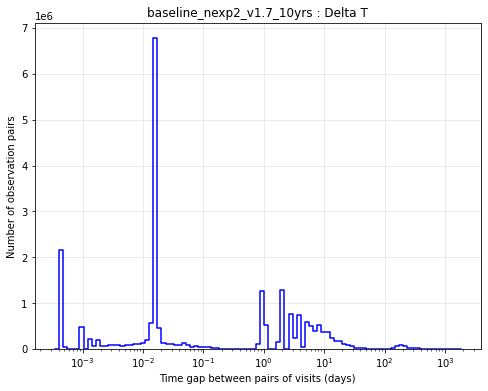

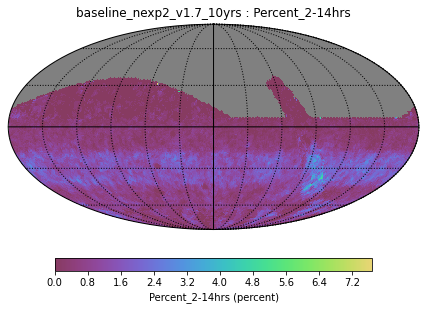

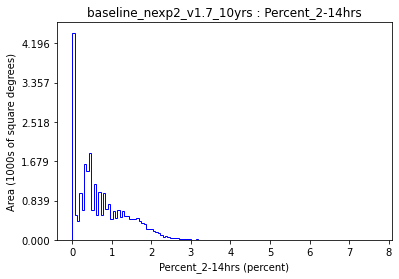

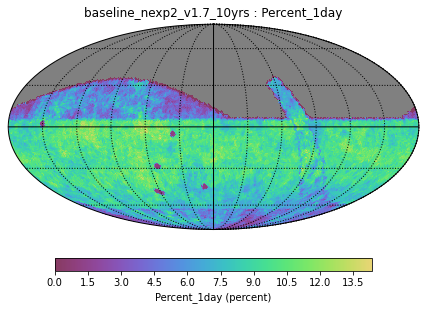

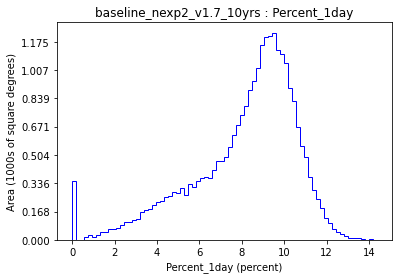

In [5]:
g.plotAll(closefigs=False)

Text(0.6666666666666666, 4267970.28, '1 d')

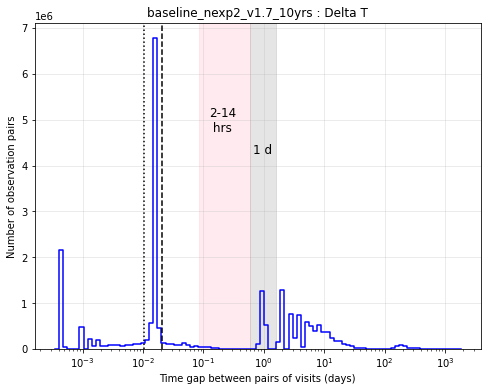

In [6]:
# We can make the tgaps plot look a little nicer .. 
ph = maf.PlotHandler(outDir=outDir, thumbnail=False, savefig=False)
ph.setMetricBundles([bundles['tgaps']])
plotDict = {'bins': tgaps, 'xscale': 'log', 'yMin': 0, 'figsize': (8, 6), 
            'ylabel': 'Number of observation pairs', 
            'xlabel': 'Time gap between pairs of visits (days)'}
ph.plot(plotFunc=maf.SummaryHistogram(), plotDicts=plotDict)

y1, y2 = plt.ylim()
plt.fill_between([2/24, 14/24], y1=y1, y2=y2, color='pink', alpha=0.3)
plt.fill_between([14/24, 38/24], y1=y1, y2=y2, color='grey', alpha=0.2)
plt.axvline(30/60/24, linestyle='--', color='k')
plt.axvline(15/60/24, linestyle=':', color='k')
plt.text(3/24., (y2+y1)*2/3., '2-14\n hrs', fontsize='large')
plt.text(16/24., (y2+y1)*1.8/3, '1 d', fontsize='large')

Text(0.6666666666666666, 18723457.2, '1 d')

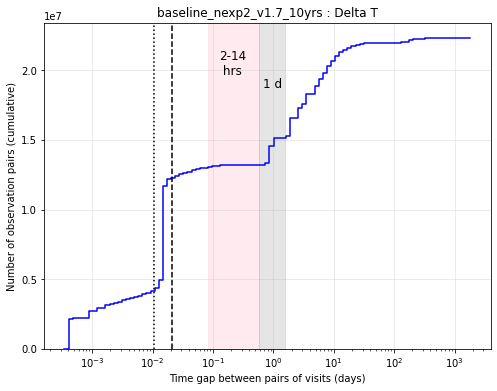

In [7]:
# And make a cumulative version
ph = maf.PlotHandler(outDir=outDir, thumbnail=False, savefig=False)
ph.setMetricBundles([bundles['tgaps']])
plotDict = {'bins': tgaps, 'xscale': 'log', 'yMin': 0, 'figsize': (8, 6), 
            'ylabel': 'Number of observation pairs (cumulative)', 
            'xlabel': 'Time gap between pairs of visits (days)',
            'color': 'blue', 'cumulative': True}
ph.plot(plotFunc=maf.SummaryHistogram(), plotDicts=plotDict)

y1, y2 = plt.ylim()
plt.fill_between([2/24, 14/24], y1=y1, y2=y2, color='pink', alpha=0.3)
plt.fill_between([14/24, 38/24], y1=y1, y2=y2, color='grey', alpha=0.2)
plt.axvline(30/60/24, linestyle='--', color='k')
plt.axvline(15/60/24, linestyle=':', color='k')
plt.text(3/24., (y2+y1)*4.2/5., '2-14\n hrs', fontsize='large')
plt.text(16/24., (y2+y1)*4/5, '1 d', fontsize='large')

In [8]:
# And we can also look at the summary statistics from each of the TGapsPercent metrics
pd.DataFrame(bundles['percent_2-14hrs'].summaryValues, index=['2-14 hours'])

,Mean,Rms,Median,Max,Min,N(+3Sigma),N(-3Sigma),Count,25th%ile,75th%ile
2-14 hours,0.773323,0.655573,0.598086,7.692308,0.0,203,0,32612,0.252127,1.210654


In [9]:
# And we can also look at the summary statistics from each of the TGapsPercent metrics
pd.DataFrame(bundles['percent_1day'].summaryValues, index=['1 day'])

,Mean,Rms,Median,Max,Min,N(+3Sigma),N(-3Sigma),Count,25th%ile,75th%ile
1 day,8.157599,2.463456,8.761682,14.355231,0.0,0,440,32612,6.883172,9.872082


## Compare with another simulation ## 

This could be extended to work with multiple simulations, but adding even one additional simulation demonstrates the effect.

In [10]:
dbfile = '/Users/lynnej/opsim/fbs_v2.0/baseline/baseline_v2.0_10yrs.db'
runName = os.path.split(dbfile)[-1].replace('.db', '')
opsdb = maf.db.OpsimDatabase(dbfile)

print(runName)

baseline_v2.0_10yrs


In [11]:
slicer = maf.slicers.HealpixSlicer(nside=nside)
bundles2 = {}

tMin = 30/60/60/24.   # 30s
tMax = 5*365.25   # 5 years
tgaps = np.logspace(np.log10(tMin), np.log10(tMax), 100)

m1 =  maf.metrics.TgapsMetric(bins=tgaps, allGaps=False, metricName='Delta T')
plotDict = {'bins': tgaps, 'xscale': 'log', 'yMin': 0, 'figsize': (8, 6), 
            'ylabel': 'Number of observation pairs', 
            'xlabel': 'Time gap between pairs of visits (days)'}
plotFuncs = [maf.plots.SummaryHistogram()]

bundles2['tgaps'] = maf.MetricBundle(m1, slicer, constraint=None, 
                                   runName=runName, plotDict=plotDict, plotFuncs=plotFuncs)


m2 =  maf.metrics.TgapsPercentMetric(minTime=2/24., maxTime=14/24., allGaps=False, 
                                 metricName='Percent_2-14hrs')
m3 =  maf.metrics.TgapsPercentMetric(minTime=14./24., maxTime=(14./24 + 1.), allGaps=False, 
                                 metricName='Percent_1day')

plotFuncs = [maf.plots.HealpixSkyMap(), maf.plots.HealpixHistogram()]
plotDict = {'colorMin': 0}
summaryMetrics = maf.extendedSummary()

bundles2['percent_2-14hrs'] = maf.MetricBundle(m2, slicer, constraint=None,
                                            runName=runName, summaryMetrics=summaryMetrics,
                                             plotDict=plotDict, plotFuncs=plotFuncs)
bundles2['percent_1day'] = maf.MetricBundle(m3, slicer, constraint=None,
                                         runName=runName, summaryMetrics=summaryMetrics,
                                         plotDict=plotDict, plotFuncs=plotFuncs)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [12]:
g = maf.MetricBundleGroup(bundles2, opsdb, outDir=outDir, resultsDb=resultsDb)
g.runAll()

Querying database observations with no constraint for columns ['fieldRA', 'observationStartMJD', 'fieldDec', 'rotSkyPos'].
Found 2084626 visits
Running:  ['tgaps', 'percent_2-14hrs', 'percent_1day']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "" constraint now.


0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


Plotting complete.


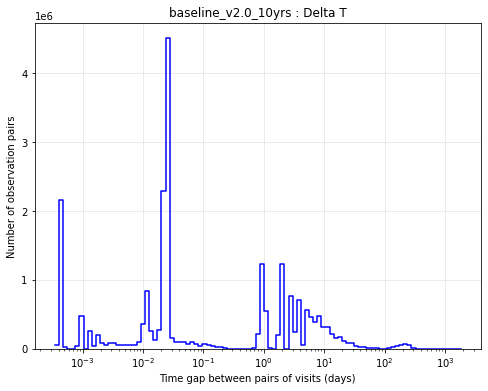

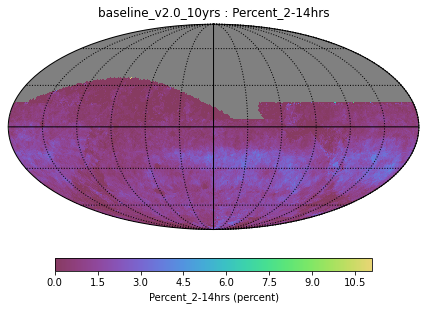

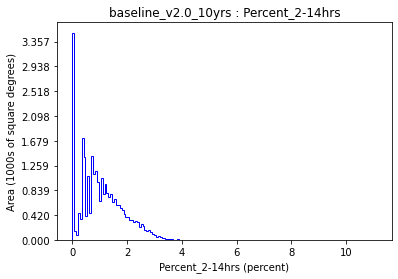

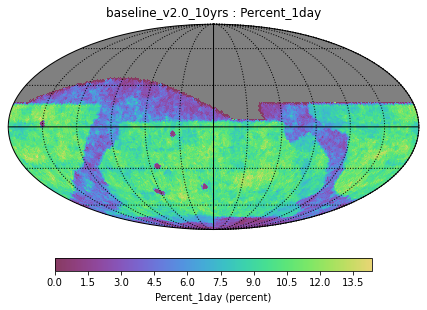

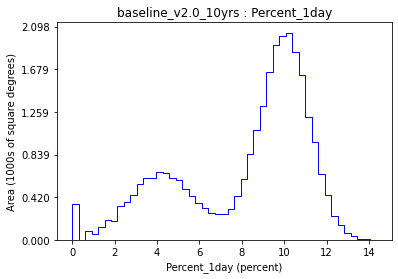

In [13]:
g.plotAll(closefigs=False)

Text(0.6666666666666666, 4267970.28, '1 d')

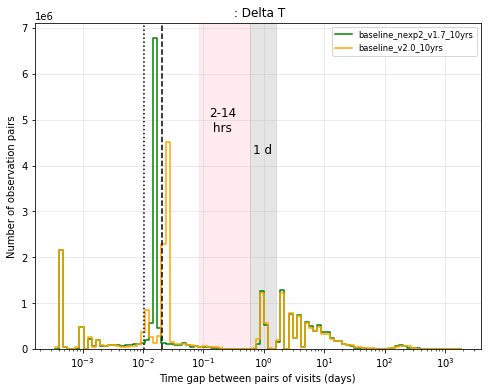

In [14]:
# And plot both of the summary histograms of the tgaps together
ph = maf.PlotHandler(outDir=outDir, thumbnail=False, savefig=False)
ph.setMetricBundles([bundles['tgaps'], bundles2['tgaps']])
bundles['tgaps'].plotDict['color'] = 'green'
bundles2['tgaps'].plotDict['color'] = 'orange'
ph.plot(plotFunc=maf.SummaryHistogram(), plotDicts=plotDict)

y1, y2 = plt.ylim()
plt.fill_between([2/24, 14/24], y1=y1, y2=y2, color='pink', alpha=0.3)
plt.fill_between([14/24, 38/24], y1=y1, y2=y2, color='grey', alpha=0.2)
plt.axvline(30/60/24, linestyle='--', color='k')
plt.axvline(15/60/24, linestyle=':', color='k')
plt.text(3/24., (y2+y1)*2/3., '2-14\n hrs', fontsize='large')
plt.text(16/24., (y2+y1)*1.8/3, '1 d', fontsize='large')

(0.00034722222222222224, 6)

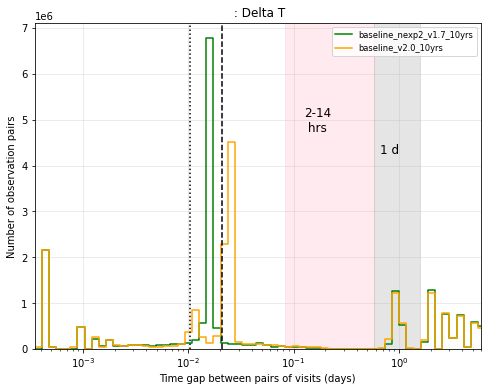

In [15]:
# And plot both of the summary histograms of the tgaps together
ph = maf.PlotHandler(outDir=outDir, thumbnail=False, savefig=False)
ph.setMetricBundles([bundles['tgaps'], bundles2['tgaps']])
bundles['tgaps'].plotDict['color'] = 'green'
bundles2['tgaps'].plotDict['color'] = 'orange'
ph.plot(plotFunc=maf.SummaryHistogram(), plotDicts=plotDict)

y1, y2 = plt.ylim()
plt.fill_between([2/24, 14/24], y1=y1, y2=y2, color='pink', alpha=0.3)
plt.fill_between([14/24, 38/24], y1=y1, y2=y2, color='grey', alpha=0.2)
plt.axvline(30/60/24, linestyle='--', color='k')
plt.axvline(15/60/24, linestyle=':', color='k')
plt.text(3/24., (y2+y1)*2/3., '2-14\n hrs', fontsize='large')
plt.text(16/24., (y2+y1)*1.8/3, '1 d', fontsize='large')
plt.xlim(30/60/60/24, 6)